In [1]:
%load_ext autoreload
%autoreload 3 --log
%autoreload?

Docstring:
::

  %autoreload [-p] [-l] [--hide-errors] [mode]

%autoreload => Reload modules automatically

%autoreload or %autoreload now
Reload all modules (except those excluded by %aimport) automatically
now.

%autoreload 0 or %autoreload off
Disable automatic reloading.

%autoreload 1 or %autoreload explicit
Reload only modules imported with %aimport every time before executing
the Python code typed.

%autoreload 2 or %autoreload all
Reload all modules (except those excluded by %aimport) every time
before executing the Python code typed.

%autoreload 3 or %autoreload complete
Same as 2/all, but also but also adds any new objects in the module. See
unit test at IPython/extensions/tests/test_autoreload.py::test_autoload_newly_added_objects

The optional arguments --print and --log control display of autoreload activity. The default
is to act silently; --print (or -p) will print out the names of modules that are being
reloaded, and --log (or -l) outputs them to the log at INFO level.

In [2]:
from stpy.kernels import KernelFunction
from stpy.borel_set import BorelSet,HierarchicalBorelSets
from stpy.point_processes.poisson_rate_estimator import PoissonRateEstimator
import torch 
import pandas as pd
import geopandas
import numpy as np 
import matplotlib.pyplot as plt
import contextily as ctx
from scipy.interpolate import griddata
from stpy.point_processes.poisson.poisson import PoissonPointProcess
from sensepy.capture_thompson import CaptureThompson
import time
from utils import *

2024-10-12 11:55:18.449582: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-12 11:55:18.465094: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-12 11:55:18.470051: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-12 11:55:18.483398: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-12 11:55:19.401574: W tensorflow/compiler/tf2

In [3]:
estimator = PoissonRateEstimator(
    HierarchicalBorelSets(
        d=2, interval=[(-1, 1), (-1, 1)], levels=8
    ),  # 4^(8-1) cells in the lowest level
    d=2,
    kernel=KernelFunction(kernel_name="squared_exponential", gamma=0.12, d=2),
    max_intensity=10.0e10,  # maximal value of the rate function
    min_intensity=0.1,  # minimal value of the rate function
    basis_size_per_dim=10,  # number of basis functions along each axis
    jitter=10e-3,
    langevine_sampling_steps=200,  # langevin steps for sampling
    optimization_library="cvxpy",
    use_anchors=False
)
Num_data_points = 200
name = "./sensepy/sensepy/benchmarks/data/taxi_data.csv"
# borel set a square with boundaries [-1,1]^2
D = BorelSet(2, bounds=torch.Tensor([[-1., 1.], [-1, 1]]).double())

Precomputing phis.
Precomputation finished.


In [4]:
name = "sensepy/sensepy/benchmarks/data/taxi_data.csv"
# borel set a square with boundaries [-1,1]^2
D = BorelSet(2, bounds=torch.Tensor([[-1.0, 1.0], [-1, 1]]).double())
data, gdf = get_taxi_data(200, D)

In [5]:
# load data in the above format
st = time.process_time()
estimator.load_data(data)
et = time.process_time()
print("Time to load data: ", et-st)

Time to load data:  3.9951638999999943


In [6]:
# fit the Cox process by calculating MAP. Method is defined by estimator.estimator
# it is set to penalized_likelihood, so we do the posterior GP approximation by
# the sensing paper. Also estimator.feedback is set to count-record so no histogram
# By default dual = True which means that data is split into buckets that
# are given by the quadtree
estimator.dual = False
st = time.process_time()
estimator.fit_gp()
et = time.process_time()
print("Time to fit GP: ", et-st)

Time to fit GP:  1.05537360000001


/home/paul/semesterprojekt/.env/lib/python3.10/site-packages/cvxpy/reductions/solvers/conic_solvers/mosek_conif.py:654: UserWarning: 
Using MOSEK constants to specify parameters is deprecated.
Use generic string names instead.
For example, replace mosek.iparam.num_threads with 'MSK_IPAR_NUM_THREADS'

  warnings.warn(__MSK_ENUM_PARAM_DEPRECATION__, UserWarning)


In [7]:
left, down, right, up = gdf.total_bounds

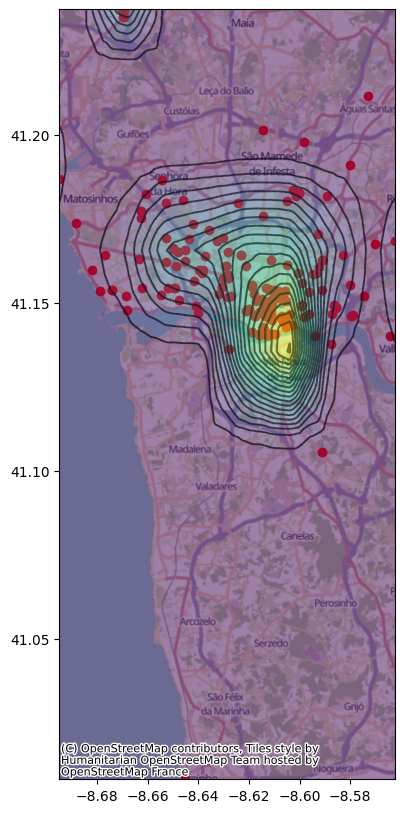

In [8]:
# Plotting the fitted Map
# get min and max longitude from gdf

n = 30  # discretization
xtest = D.return_discretization(n)
Map = BorelSet(d=2, bounds=torch.Tensor([[left, right], [down, up]]).double())
xtest_orig = Map.return_discretization(n).numpy()

f = estimator.rate_value(xtest)

xx = xtest_orig[:, 0]
yy = xtest_orig[:, 1]

grid_x, grid_y = np.mgrid[min(xx) : max(xx) : 100j, min(yy) : max(yy) : 100j]
grid_z_f = griddata(
    (xx, yy), f[:, 0].detach().numpy(), (grid_x, grid_y), method="linear"
)

fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color="red", figsize=(10, 10))
cs = ax.contourf(grid_x, grid_y, grid_z_f, levels=20, alpha=0.5)
ax.contour(cs, colors="k", alpha=0.5)
ctx.add_basemap(ax, crs=gdf.crs.to_string())